# Covid Sentiment Analysis

## Importing libraries

In [1]:
# Standard data manipulation and visualization libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats
from scipy.stats import chi2_contingency

# Natural Language Processing libraries
import contractions
from nltk.tokenize import word_tokenize
from nltk import bigrams, trigrams
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
import nlpaug.augmenter.word as naw

# Text preprocessing and manipulation libraries
import codecs
import unidecode
import re
from collections import Counter
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import words

# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm')

from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

## Importing the dataset

In [3]:
# Importing the dataset
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin')
df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin')

# Checking columns in the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


### Corpora Description

In [4]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
print("Train data duration:", (train_duration := df_train['TweetAt'].apply(pd.Timestamp).max() - df_train['TweetAt'].apply(pd.Timestamp).min()), "from", (train_start_date := df_train['TweetAt'].apply(pd.Timestamp).min()), 'to', (train_end_date := df_train['TweetAt'].apply(pd.Timestamp).max()))
print("Test data duration:", (test_duration := df_test['TweetAt'].apply(pd.Timestamp).max() - df_test['TweetAt'].apply(pd.Timestamp).min()), "from", (test_start_date := df_test['TweetAt'].apply(pd.Timestamp).min()), 'to', (test_end_date := df_test['TweetAt'].apply(pd.Timestamp).max()))

Train data duration: 335 days 00:00:00 from 2020-01-04 00:00:00 to 2020-12-04 00:00:00
Test data duration: 304 days 00:00:00 from 2020-02-03 00:00:00 to 2020-12-03 00:00:00


The train and test data have overlapping duration ensures that the model learns from a diverse range of temporal contexts, enhancing its robustness and applicability.

In [6]:
# Locations

print("Number of different locations: ", df_train['Location'].nunique())

Number of different locations:  12220


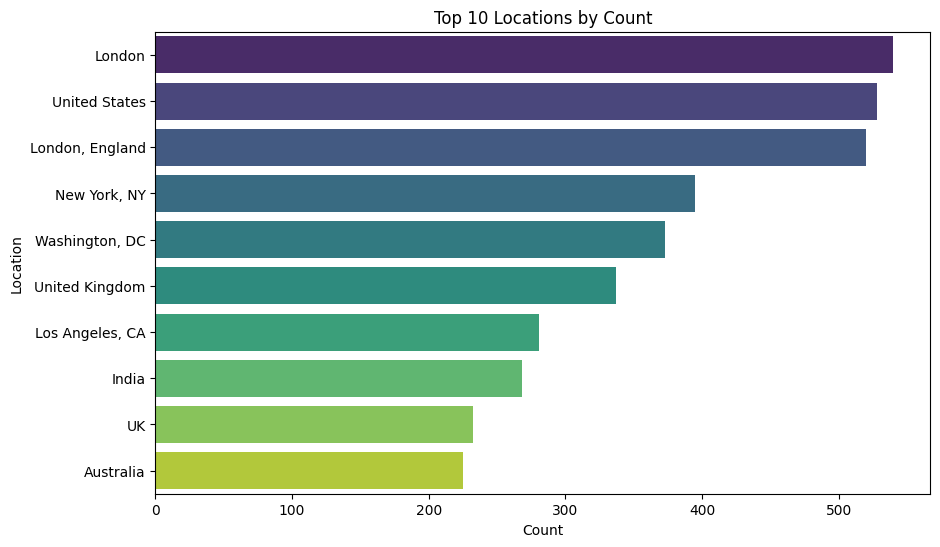

In [7]:
top_locations = df_train['Location'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Top 10 Locations by Count')
plt.show()

Locations are overlapping and are not unique, for instance, variations such as "London UK" and "London, UK" are treated as distinct locations. We can see that there are people from several regions (US, US, India, Australia) tweeting hence there could be linguistic variations and sentiments expression, slangs usage, geographical contexts may differ significantly, influenced by the prevailing circumstances during the COVID-19 pandemic. 

For the purposes of this project, we will aim to mitigate the effects of regional variations by disregarding specific geographical regions. This approach acknowledges the complexity introduced by diverse locations, opting instead to focus on broader linguistic and sentiment patterns within the dataset.

Not sure how these were annotated though. Assuming that the annotations were done in a standardized and consistent way to ensure uniformity across the dataset, we'll proceed with our analysis.

In [8]:
# We only need the Tweet and Sentiment as our columns, removing everything else
df_train = df_train[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'tweets', 'Sentiment': 'sentiment'})
df_test = df_test[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'tweets', 'Sentiment': 'sentiment'})

df_train.head()

,tweets,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Exploratory Data Analysis

1. Exploratory Data Analsis (EDA): look closely at you data, the text, the target, any null values, any imbalance, non-numerical data to be converted (in data and target)?, etc.

In [9]:
# Checking info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweets     41157 non-null  object
 1   sentiment  41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [10]:
print("Null values in the train dataset:")
display(df_train.isna().mean())
print("Null values in the test dataset:")
display(df_test.isna().mean())

Null values in the train dataset:


tweets       0.0
sentiment    0.0
dtype: float64

Null values in the test dataset:


tweets       0.0
sentiment    0.0
dtype: float64

There are total of 41157 rows and 2 columns with no null values.

In [11]:
print("Classes in train dataset: ")
display(df_train.sentiment.value_counts())

Classes in train dataset: 


sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

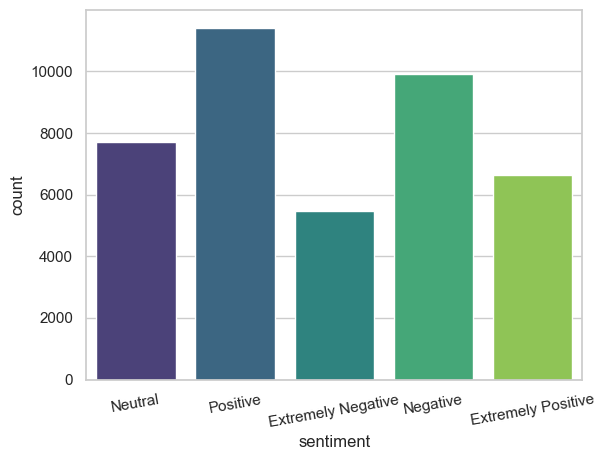

In [12]:
# Plotting the distribution of classes
sns.set(style="whitegrid")
sns.countplot(x='sentiment', data=df_train, palette='viridis')
plt.xticks(rotation=10)
plt.show()

There is clearly an imbalance in the dataset that will will look at later in this notebook.

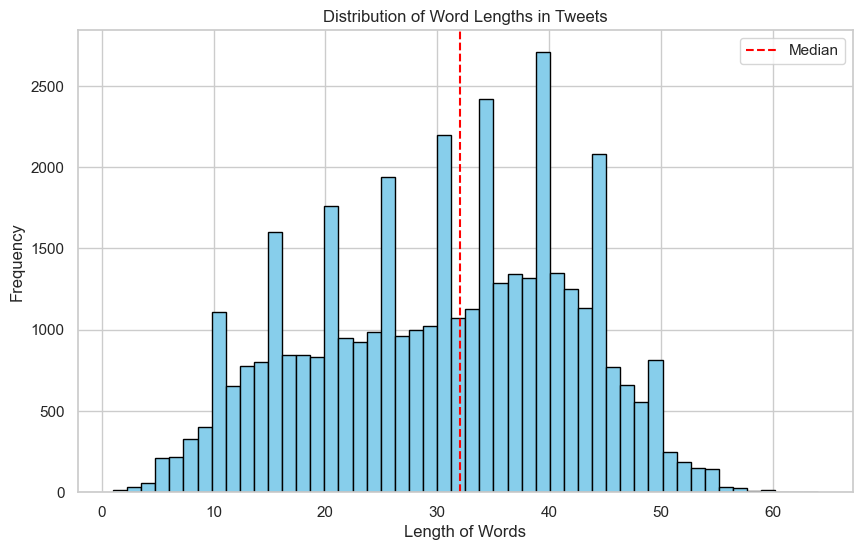

In [13]:
word_lengths = df_train['tweets'].apply(lambda x: len(x.split()))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=word_lengths.median(), color='red', linestyle='--', label='Median')
plt.title('Distribution of Word Lengths in Tweets')
plt.xlabel('Length of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In 2020, the character length for twitter was 280 characters which can be seen here as a maximum of 60 words including hashtags or emojis as well. Here, we can see that there are more tweets with shorter word lengths than those with longer word length and median falls somewhere between 30-35 words that can be considered while choosing max word length later in this notebook.

In [14]:
# Checking tweets with short length
df_train[df_train['tweets'].str.len() < 15]

,tweets,sentiment
9776,Be like Bob,Positive
12047,only in France,Neutral
15577,Tissue Issue,Neutral
16872,Cartoon for,Neutral
19410,BREAKING NEWS,Neutral
20467,Omg y all,Neutral
22433,Man needs a,Neutral
29981,The CNP Report,Neutral
35526,amp,Neutral
37996,Crisis averted,Extremely Negative


In [15]:
# Checking if character length has a relationship with sentiment since most of short tweets are "Neutral"
df_train['char_length'] = df_train['tweets'].apply(len)

# Get the character lengths for each sentiment category
lengths_positive = df_train[df_train['sentiment'] == 'Positive']['char_length']
lengths_neutral = df_train[df_train['sentiment'] == 'Neutral']['char_length']
lengths_ext_negative = df_train[df_train['sentiment'] == 'Extremely Negative']['char_length']
# Add more categories if necessary

# Perform ANOVA test
f_val, p_val = stats.f_oneway(lengths_positive, lengths_neutral, lengths_ext_negative)  # Add more categories if necessary

print(f"F-value: {f_val}, P-value: {p_val}")

F-value: 1198.5446189935556, P-value: 0.0


The F-value obtained is quite high, and a P-value of 0.0 suggests that the result is highly significant. This indicates that there is a statistically significant difference in tweet character lengths among the different sentiment categories.

What this means is that we can reject the null hypothesis that there is no variation in tweet lengths across the sentiment categories. The tweet character length is likely related to the sentiment expressed in the tweets.

This is possible as it is difficult to express the sentiments strongly in shorter tweets. 

In [16]:
df_train.drop(columns='char_length', inplace=True)

In [17]:
pd.set_option('display.max_colwidth', None)
print(df_train.loc[df_train['sentiment']=='Extremely Positive']['tweets'].head(20))

11                                                                                                      Due to the Covid-19 situation, we have increased demand for all food products. \r\r\n\r\r\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \r\r\n\r\r\nWe thank you for your patience during this time.
12                                                                    #horningsea is a caring community. LetÂs ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has. https://t.co/lsGrXXhjhh
18                                                      Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries\r\r\nÂAs COVID-19 has spread, weÂve seen a significant increase in people shopping online for groceries,Â a spokeswoman said in a statement. ÂToday this resulted in a systems impac

**We have some duplicates as well.** No, what seemed to be duplicate here i.e., 22nd and 23rd tweets actually have differences in the #hastags order. Even if we were to consider a 90% threshold for matching duplicates, it could still be influenced by variations in word length. For instance, a longer tweet may contain substantially different words within the 10% margin of differing characters. As a result, for this project we will not do anything for duplicated text that is slightly different.

**Inaccurate Annotations** Some tweets here do not seem very accurately annotated for example, "Never thought I'd say this, but. 2019, Will you come back!? PLEASE! #coronavirus #COVID19 #peoplearelosingtheirminds #StopTheMadness #stoppanicbuyin" This is an Extremely Positive category tweet according to this dataset, there may be a need to relook at the annotations, could use "Active Learning" or "Semi-Supervised Learning". 

In [18]:
print(df_train.loc[df_train['sentiment']=='Positive']['tweets'].head(20))

1                                                                                         advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
2                                                                                                                                                                                                   Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
3     My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
5               

In [19]:
print(df_train.loc[df_train['sentiment']=='Neutral']['tweets'].head(20))

0                                                                                                                                                                                                            @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
7                                                                                                                                                                                              Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ
10                                      All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a single supermarket. #manila #lockdown #covid2019 #Philippines https://t.co/HxWs9LAnF9
16                                               

Some of the neutral texts only contain, html tags/punctuations/stop words hence leaving us with a very short text or even empty text after cleaning which confirms the hypothesis that it is difficult to identify the sentiment for short tweets, let us see if our models are able to capture this. This may not always be true as we have seen a couple of example of short texts that were not neutral.

In [20]:
print(df_train.loc[df_train['sentiment']=='Negative']['tweets'].head(20))

9                                  For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona
24                                             @10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checkout staff to police the actions of the selfish and profiteer
26                                                                                                  In preparation for higher demand and a potential food shortage, The Hunger Coalition purchased 10 percent more food and implemented new protocols due to the COVID-19 coronavirus. https://t.co/5CecYtLnYn
28     Do you see malicious price increases in NYC? The NYC Department of Consumer and Work

In [21]:
print(df_train.loc[df_train['sentiment']=='Extremely Negative']['tweets'].head(20))

4      Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n
20                                                                            with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale
27                                               This morning I tested positive for Covid 19. I feel ok, I have no symptoms so far but have been isolated since I found out about my possible exposure to the virus.  Stay home people and be pragmatic. I will keep you updated on how IÂm doing ???? No panic. https://t.co/Lg7HVMZglZ
29        

We can see the tweets have the following that we may need to clean:
1. @mentions: Remove anything after @mention till space
2. #hashtags (same as punctuation): This may still remain a problem as there are no spaces when dealing with hashtag words so it will be difficult to separate them. 
3. hyperlinks
4. punctuations
5. special characters such as "Â"
6. numbers
7. dates
8. contractions
9. spelling corrections

The tweets have differences in words and sentiments. However, we can notice that the casing does not have much impact on the strength/different of the sentiment when it comes to Positive/Extremely positive or Positive/Negative since there are casing differences, All caps present in all sentiments. 

In [22]:
# Checking the impact of all caps in Postive/Extremely Postitive and Negative/Extremely Negative

df_train['tweets_lower'] = df_train['tweets'].str.lower()  
# Check if tweet contains four consecutive uppercase characters
df_train['has_consecutive_caps'] = df_train['tweets'].apply(has_consecutive_caps)
display(df_train['has_consecutive_caps'].mean())
display(df_train.head())

# Create a subset of the DataFrame for extremely positive/negative and positive/negative tweets
extremely_positive_negative = df_train[df_train['sentiment'].isin(['Extremely Positive', 'Extremely Negative'])]
positive_negative = df_train[df_train['sentiment'].isin(['Positive', 'Negative'])]

# Print distribution of sentiment classes for tweets with and without four consecutive uppercase characters
print("Distribution of sentiment classes for tweets with four consecutive uppercase characters:")
print(extremely_positive_negative['sentiment'].value_counts(normalize=True))
print("\nDistribution of sentiment classes for tweets without four consecutive uppercase characters:")
print(positive_negative['sentiment'].value_counts(normalize=True))

# perform a statistical test to determine if there's a significant association between sentiment and the presence of four consecutive uppercase characters.
# using chi-square test:
contingency_table = pd.crosstab(df_train['has_consecutive_caps'], df_train['sentiment'])
print("\nContingency table:")
print(contingency_table)
# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print("\nChi-square test p-value:", p)

0.7914085088806279

,tweets,sentiment,tweets_lower,has_consecutive_caps
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,@menyrbie @phil_gahan @chrisitv https://t.co/ifz9fan2pa and https://t.co/xx6ghgfzcc and https://t.co/i2nlzdxno8,True
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order,True
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"coronavirus australia: woolworths to give elderly, disabled dedicated shopping hours amid covid-19 outbreak https://t.co/binca9vp8p",True
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,"my food stock is not the only one which is empty...\r\r\n\r\r\nplease, don't panic, there will be enough food for everyone if you do not take more than you need. \r\r\nstay calm, stay safe.\r\r\n\r\r\n#covid19france #covid_19 #covid19 #coronavirus #confinement #confinementotal #confinementgeneral https://t.co/zrlg0z520j",True
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,"me, ready to go at supermarket during the #covid19 outbreak.\r\r\n\r\r\nnot because i'm paranoid, but because my food stock is litteraly empty. the #coronavirus is a serious thing, but please, don't panic. it causes shortage...\r\r\n\r\r\n#coronavirusfrance #restezchezvous #stayathome #confinement https://t.co/usmualq72n",True


Distribution of sentiment classes for tweets with four consecutive uppercase characters:
sentiment
Extremely Positive    0.547212
Extremely Negative    0.452788
Name: proportion, dtype: float64

Distribution of sentiment classes for tweets without four consecutive uppercase characters:
sentiment
Positive    0.535264
Negative    0.464736
Name: proportion, dtype: float64

Contingency table:
sentiment             Extremely Negative  Extremely Positive  Negative  \
has_consecutive_caps                                                     
False                               1129                1321      2122   
True                                4352                5303      7795   

sentiment             Neutral  Positive  
has_consecutive_caps                     
False                    1665      2348  
True                     6048      9074  

Chi-square test p-value: 0.07656836608249476


Approximately 54.72% of the tweets with three consecutive uppercase characters are classified as Extremely Positive, and about 45.28% are classified as Extremely Negative.

About 53.53% of the tweets without three consecutive uppercase characters are classified as Positive, and roughly 46.47% are classified as Negative.

The p-value obtained from the chi-square test is 0.077, which is greater than the typical significance level of 0.05. Therefore, we fail to reject the null hypothesis, and there is no statistically significant association between the presence of 4 consecutive uppercase characters in tweets and their sentiment classification at the 5% significance level.

**Based on the statistical analysis we conducted, converting all text to lowercase may not significantly affect the sentiment analysis results.**

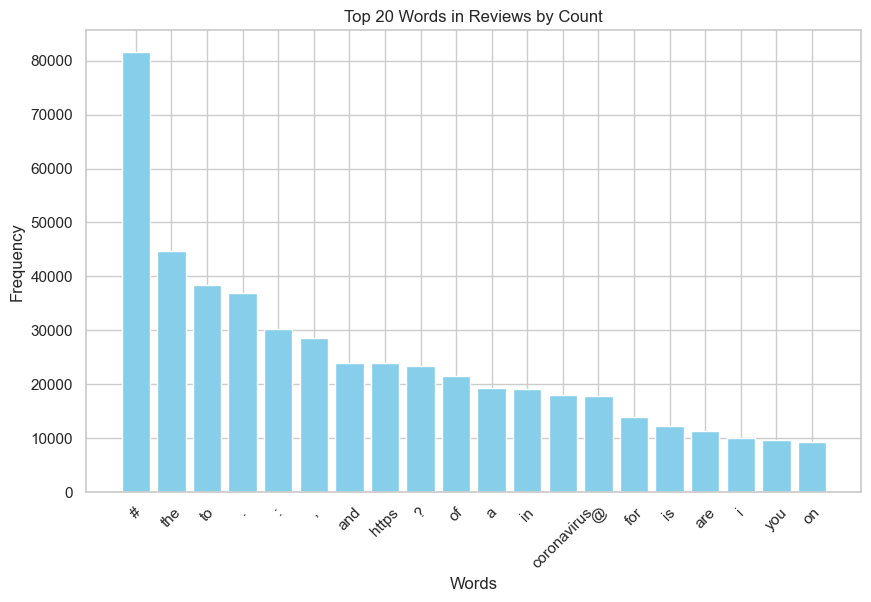

In [23]:
# Let's see the top words
plot_top_n_words(df_train['tweets'], 20)

For now it just has punctuation, stop words, html tags and common words such as coronavirus.

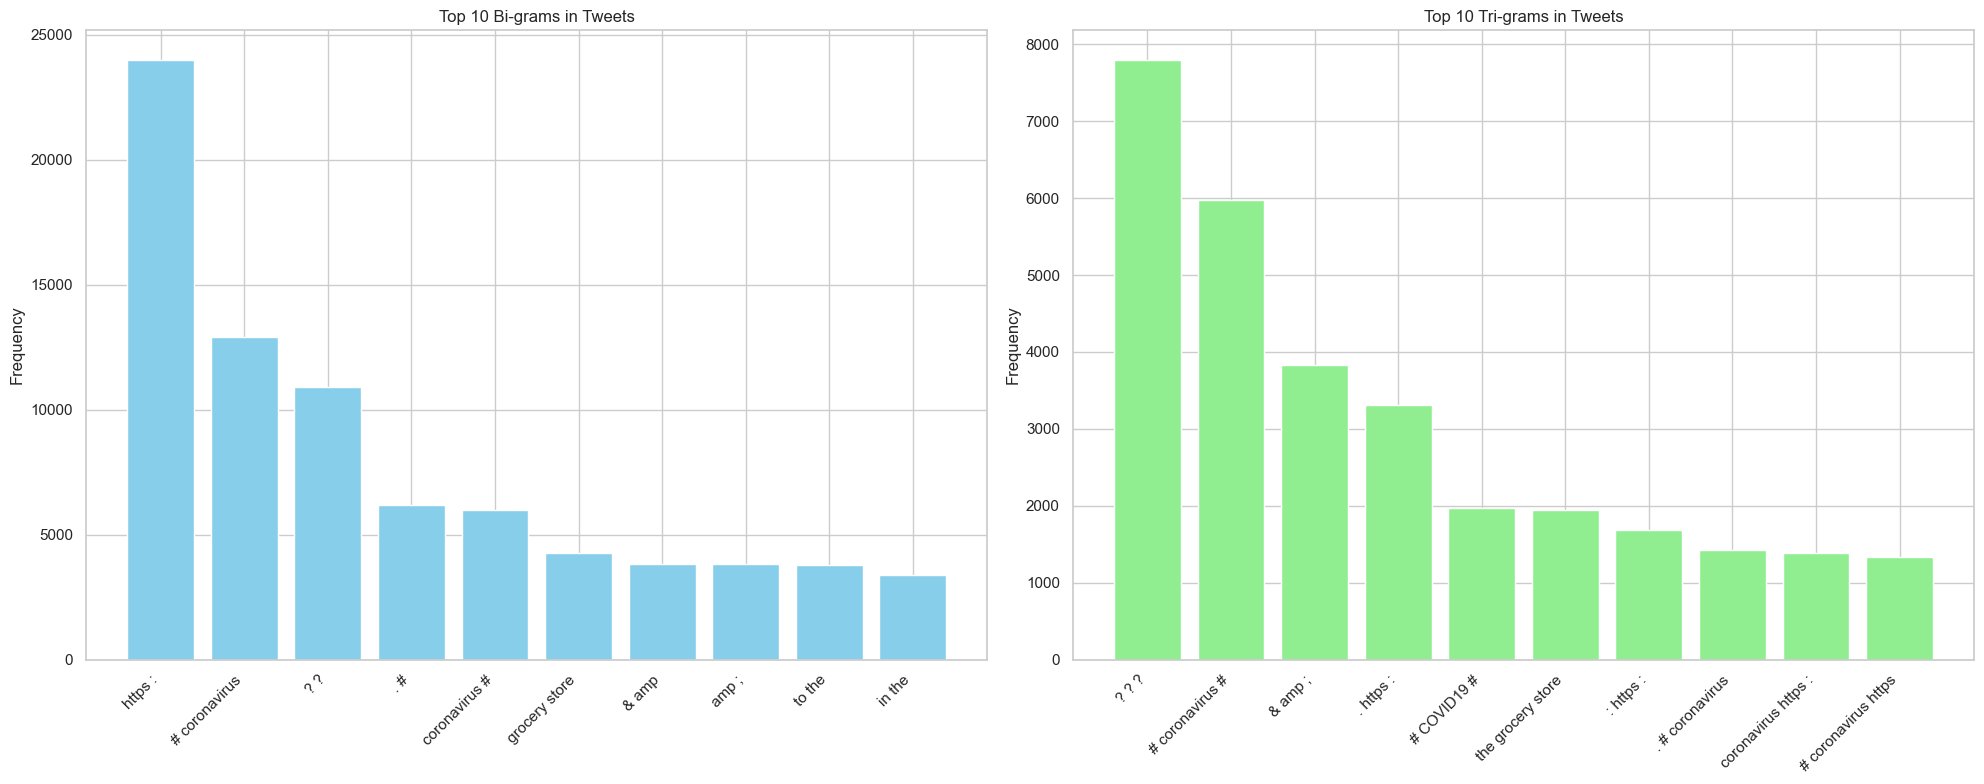

In [24]:
top_bigrams = get_top_n_bigrams(df_train['tweets'], 10)
top_trigrams = get_top_n_trigrams(df_train['tweets'], 10)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top Bi-grams
ax1.bar([' '.join(x[0]) for x in top_bigrams], [x[1] for x in top_bigrams], color='skyblue')
ax1.set_title('Top 10 Bi-grams in Tweets')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels([' '.join(x[0]) for x in top_bigrams], rotation=45, ha='right')

# Top Tri-grams
ax2.bar([' '.join(x[0]) for x in top_trigrams], [x[1] for x in top_trigrams], color='lightgreen')
ax2.set_title('Top 10 Tri-grams in Tweets')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels([' '.join(x[0]) for x in top_trigrams], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Same here, punctuations, stop words, coronavirus wtc. We will look at more common words after the initial cleaning of the text.

I will also remove words such as coronavirus, covid, covid19 as they are the most common words in this dataset and maynot add any value. 

## Data Cleaning

2. Split the train set into Training & Validation sets (0.75, 0.25), the test set is a separate file here. NB: if you do crossvalidation, you must not split the train into train & validation.
3. Clean Textual Data

In [25]:
# Dropping duplicates
print(df_train.shape)
df_train = df_train.drop_duplicates()
print(df_train.shape)

(41157, 4)
(41157, 4)


In [26]:
# Split into train and valid

df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=42)
df_train.shape, df_valid.shape, df_test.shape

((30867, 4), (10290, 4), (3798, 2))

In [27]:
%%time

df_train['clean_text'] = df_train['tweets'].apply(lambda t: spacy_cleaner(t))
df_valid['clean_text'] = df_valid['tweets'].apply(lambda t: spacy_cleaner(t))
df_test['clean_text'] = df_test['tweets'].apply(lambda t: spacy_cleaner(t))
df_train.head()

CPU times: total: 3min 50s
Wall time: 4min


,tweets,sentiment,tweets_lower,has_consecutive_caps,clean_text
34625,Whe you are at the grocery store how can you practice #SocialDistancing from the cashier? ? #QuarantineDiaries #QuarantineLife,Neutral,whe you are at the grocery store how can you practice #socialdistancing from the cashier? ? #quarantinediaries #quarantinelife,True,whe grocery store practice socialdistancing cashier QuarantineDiaries QuarantineLife
21462,"We have had two #coronavirus opportunists contact us about ""optimizing"" their products on eBay -- one selling masks and the other who's selling homemade hand sanitizer in 3oz bottles.\r\r\n\r\r\nThis, in spite of the fact that both are actively banned on the platform.",Positive,"we have had two #coronavirus opportunists contact us about ""optimizing"" their products on ebay -- one selling masks and the other who's selling homemade hand sanitizer in 3oz bottles.\r\r\n\r\r\nthis, in spite of the fact that both are actively banned on the platform.",True,opportunist contact optimize product eBay sell mask sell homemade hand sanitizer oz bottle spite fact actively ban platform
16875,Beware of COVID 19 Scams 19 coronavirus scams what ftc d,Extremely Negative,beware of covid 19 scams 19 coronavirus scams what ftc d,True,beware Scams scam ftc
15129,New and Revised Supermarket Sweep but it s only for the COVID 19 panic and it s toilet paper and hand sanitizer,Neutral,new and revised supermarket sweep but it s only for the covid 19 panic and it s toilet paper and hand sanitizer,True,new revised Supermarket Sweep panic toilet paper hand sanitizer
40866,Have you been keeping up-to-date with the latest prices?\r\r\nhttps://t.co/p1KtgcwhAC,Neutral,have you been keeping up-to-date with the latest prices?\r\r\nhttps://t.co/p1ktgcwhac,False,keep date late price


In [28]:
# Examining clean text
print(df_train['tweets'][3])
print(df_train['clean_text'][3])

My food stock is not the only one which is empty...

PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. 
Stay calm, stay safe.

#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
food stock panic food need stay calm stay safe confinement Confinementotal ConfinementGeneral


#### Trying to separate hashtags

In [29]:
# Load English words from NLTK corpus
word_dictionary = set(words.words())

# Remove single letters from the dictionary
for alphabet in "bcdefghjklmnopqrstuvwxyz":
    word_dictionary.remove(alphabet)

In [30]:
for i, word in enumerate(df_train['tweets'][3].split()):
    if word.startswith("#"):
        hashtag = split_hashtag_to_words_all_possibilities(word[1:])
        print(hashtag)

split_hashtag_to_words_all_possibilities("helloworld")

[]
[]
[]
[['corona', 'virus'], ['cor', 'ona', 'virus'], ['cor', 'on', 'a', 'virus']]
[['con', 'finement']]
[['C', 'on', 'fine', 'men', 'total'], ['C', 'on', 'fine', 'men', 'tot', 'al'], ['C', 'on', 'fine', 'men', 'to', 'tal'], ['C', 'on', 'fin', 'em', 'en', 'total'], ['C', 'on', 'fin', 'em', 'en', 'tot', 'al'], ['C', 'on', 'fin', 'em', 'en', 'to', 'tal'], ['C', 'on', 'fi', 'ne', 'men', 'total'], ['C', 'on', 'fi', 'ne', 'men', 'tot', 'al'], ['C', 'on', 'fi', 'ne', 'men', 'to', 'tal']]
[['C', 'on', 'finement', 'G', 'en', 'eral'], ['C', 'on', 'finement', 'G', 'en', 'er', 'al']]


[['hello', 'world']]

Would generate many possibilities to dropping this attempt for now. 

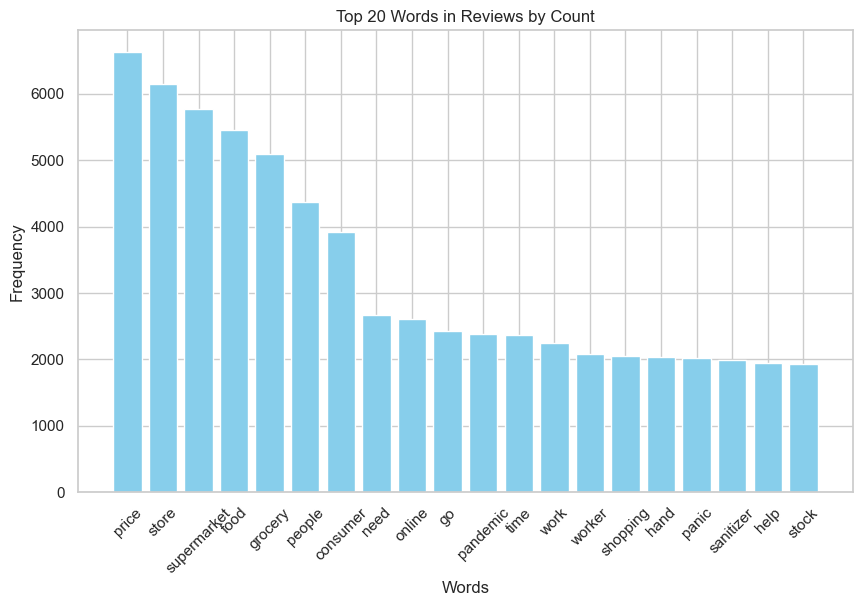

In [31]:
# Let's see the top words
plot_top_n_words(df_train['clean_text'], 20)

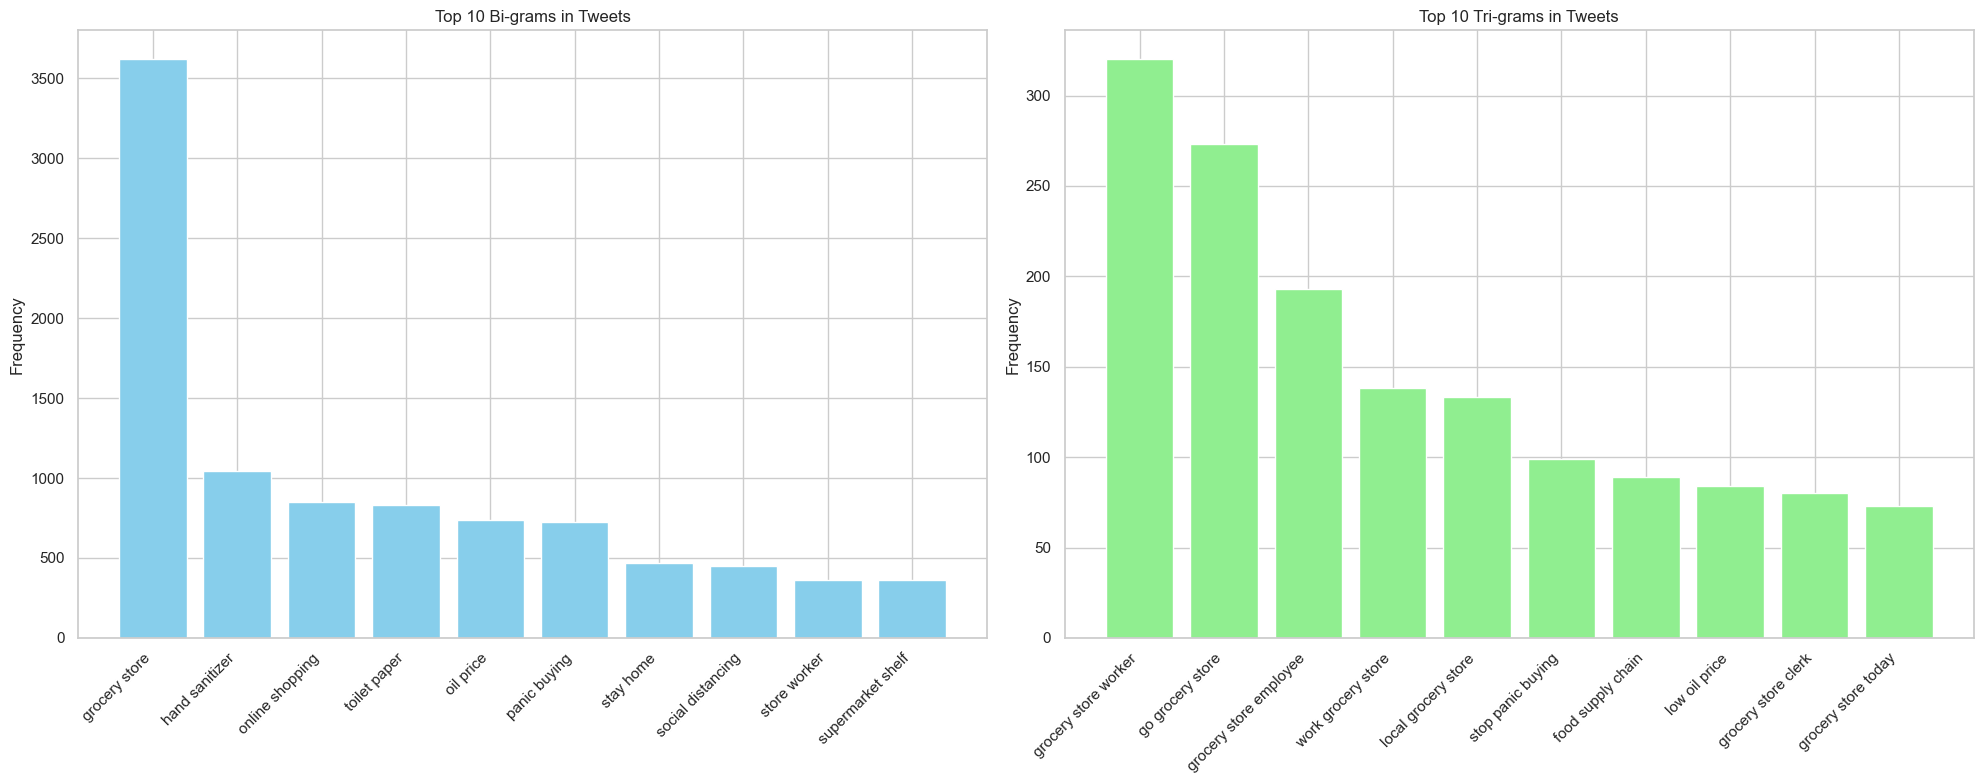

In [32]:
top_bigrams = get_top_n_bigrams(df_train['clean_text'], 10)
top_trigrams = get_top_n_trigrams(df_train['clean_text'], 10)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top Bi-grams
ax1.bar([' '.join(x[0]) for x in top_bigrams], [x[1] for x in top_bigrams], color='skyblue')
ax1.set_title('Top 10 Bi-grams in Tweets')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels([' '.join(x[0]) for x in top_bigrams], rotation=45, ha='right')

# Top Tri-grams
ax2.bar([' '.join(x[0]) for x in top_trigrams], [x[1] for x in top_trigrams], color='lightgreen')
ax2.set_title('Top 10 Tri-grams in Tweets')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels([' '.join(x[0]) for x in top_trigrams], rotation=45, ha='right')

plt.tight_layout()
plt.show()

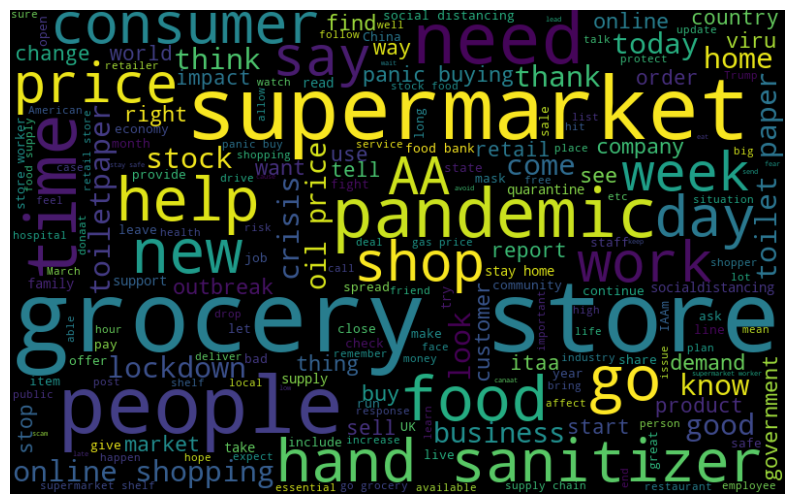

In [33]:
# create text from all tweets
all_words = ' '.join([text for text in df_train['clean_text']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

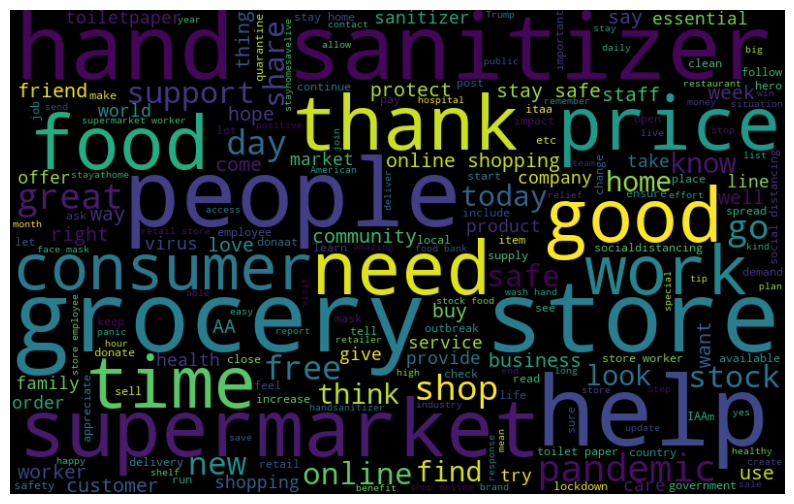

In [34]:
# create text from just Extremely Positive tweets
normal_words = ' '.join([text for text in df_train['clean_text'][df_train['sentiment'] == 'Extremely Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

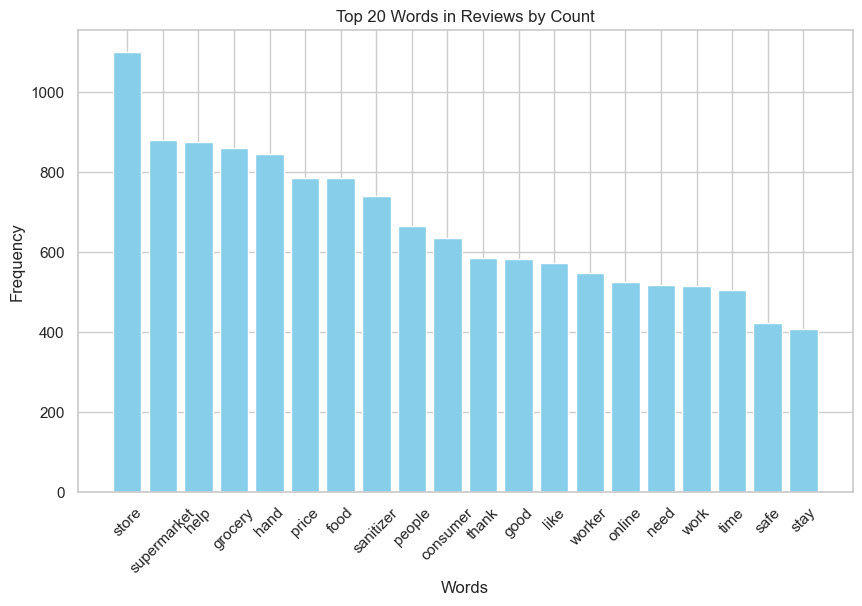

In [35]:
plot_top_n_words(df_train.loc[df_train['sentiment'] == 'Extremely Positive']['clean_text'], 20)

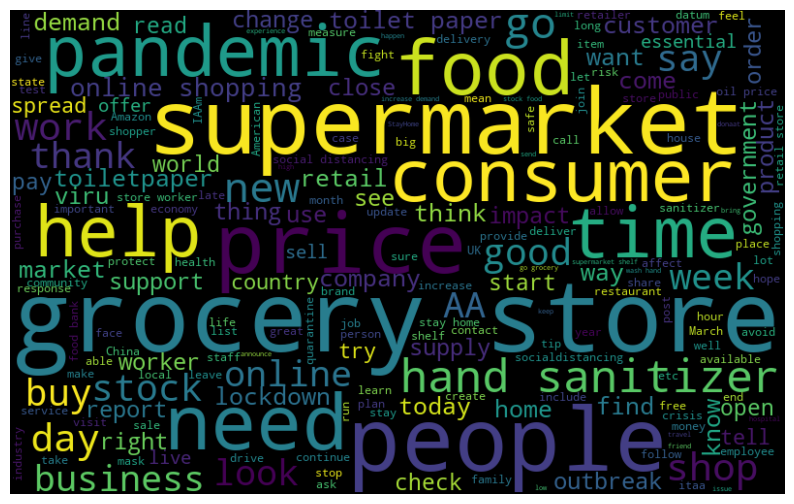

In [36]:
# create text from just Positive tweets
normal_words = ' '.join([text for text in df_train['clean_text'][df_train['sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

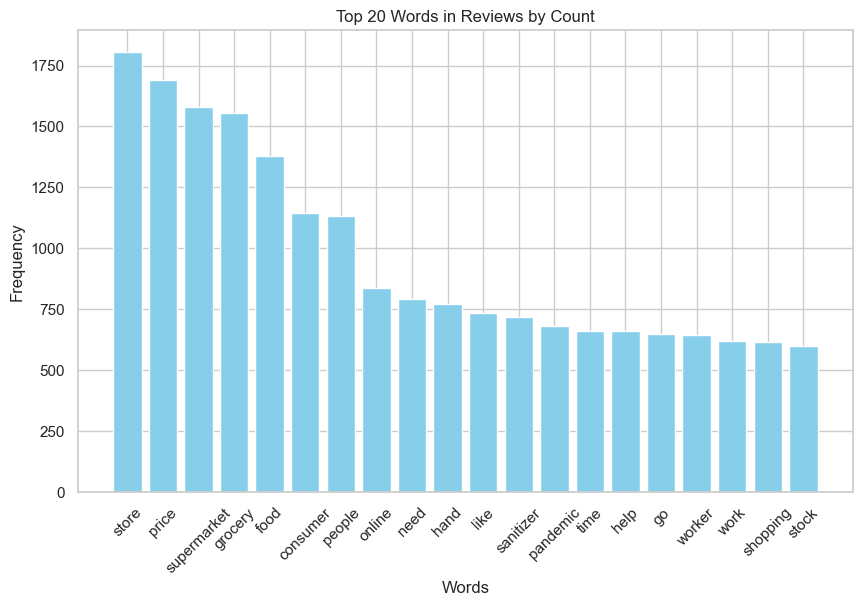

In [37]:
plot_top_n_words(df_train.loc[df_train['sentiment'] == 'Positive']['clean_text'], 20)

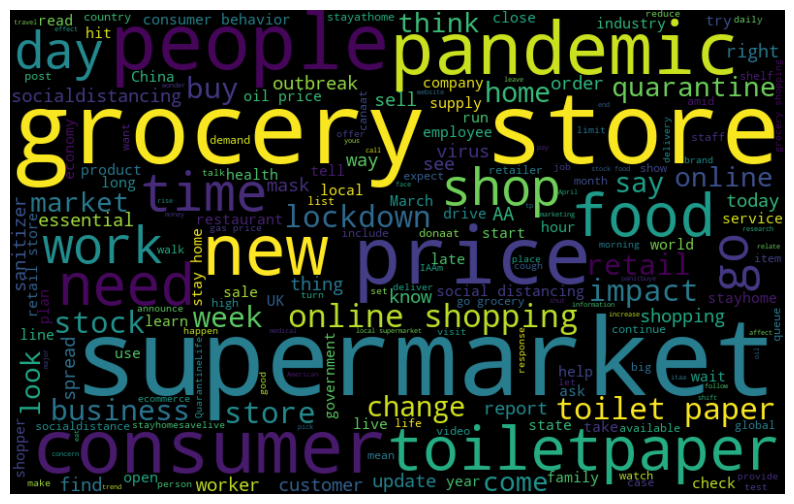

In [38]:
# create text from just Neutral tweets
normal_words = ' '.join([text for text in df_train['clean_text'][df_train['sentiment'] == 'Neutral']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

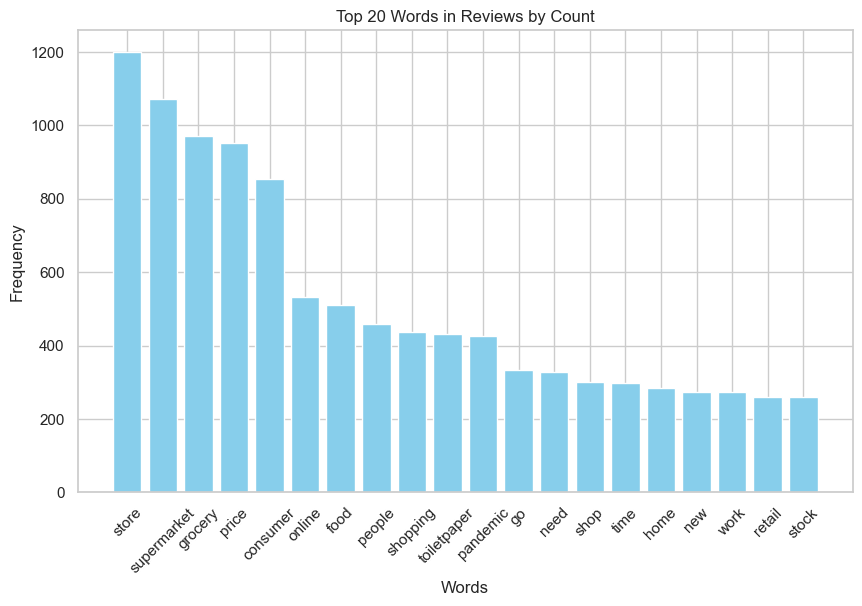

In [39]:
plot_top_n_words(df_train.loc[df_train['sentiment'] == 'Neutral']['clean_text'], 20)

Are there a lot of spaces here? Not sure.

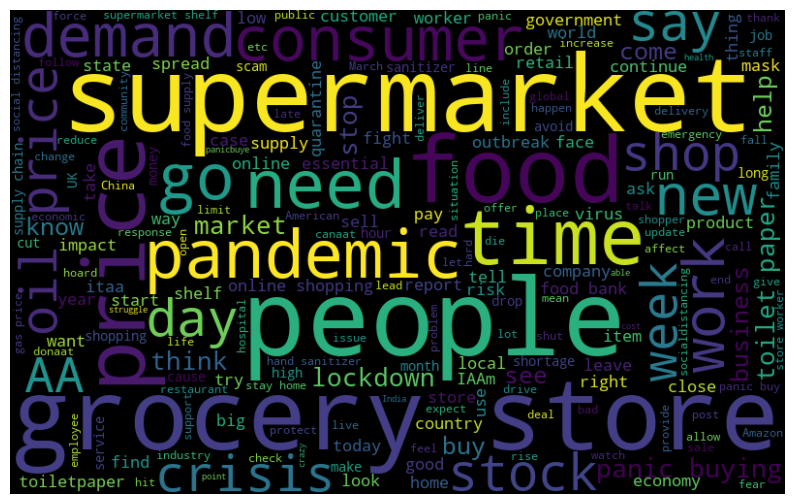

In [40]:
# create text from just Negative tweets
normal_words = ' '.join([text for text in df_train['clean_text'][df_train['sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

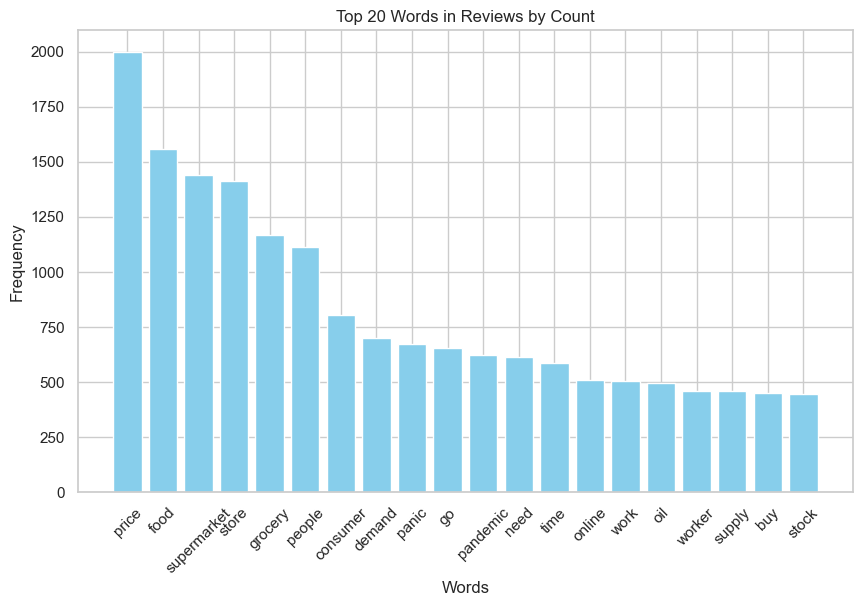

In [41]:
plot_top_n_words(df_train.loc[df_train['sentiment'] == 'Negative']['clean_text'], 20)

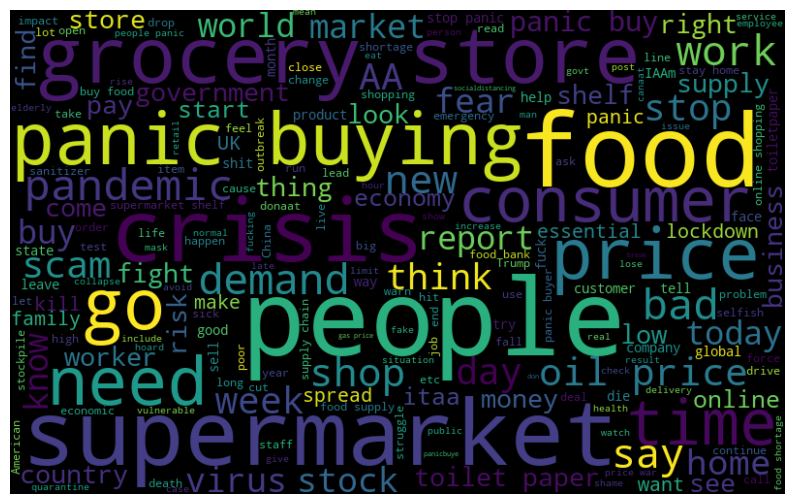

In [42]:
# create text from just Extremely Negative tweets
normal_words = ' '.join([text for text in df_train['clean_text'][df_train['sentiment'] == 'Extremely Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

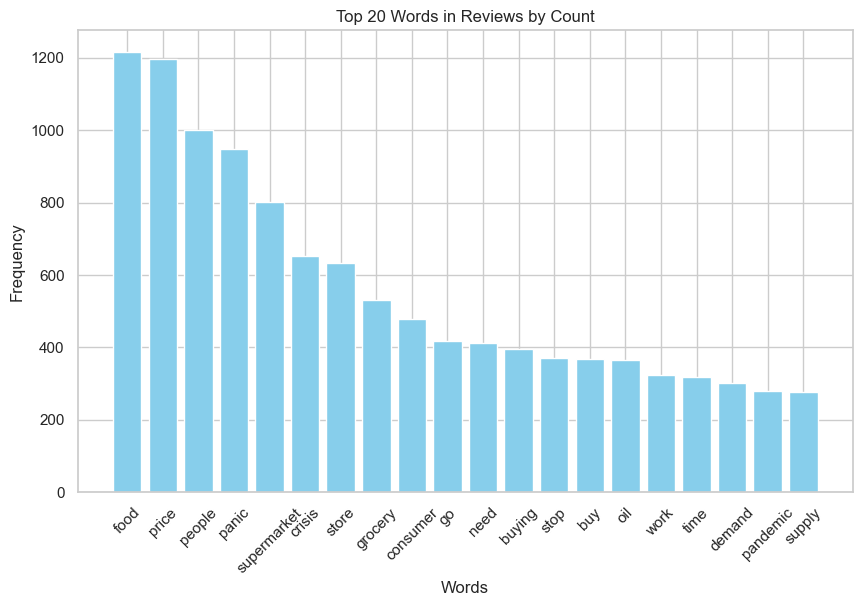

In [43]:
plot_top_n_words(df_train.loc[df_train['sentiment'] == 'Extremely Negative']['clean_text'], 20)

More common words include: "supermarket", "grocery", "market", "people", "food", "store", "pandemic", "go". Will remove them as they are present in all reviews in very high frequency. 

In [44]:
# Custom words list
words_to_remove = ["supermarket", "grocery", "market", "people", "food", "store", "pandemic", "go", 'consumer']
pattern = r'\b(?:' + '|'.join(words_to_remove) + r')\b'

# Apply the replacement on the 'reviews' column
df_train['clean_text'] = df_train['clean_text'].str.replace(pattern, '', regex=True)
df_valid['clean_text'] = df_valid['clean_text'].str.replace(pattern, '', regex=True)
df_test['clean_text'] = df_test['clean_text'].str.replace(pattern, '', regex=True)

# Optionally, you might want to remove extra spaces left after the removal
df_train['clean_text'] = df_train['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_valid['clean_text'] = df_valid['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_test['clean_text'] = df_test['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

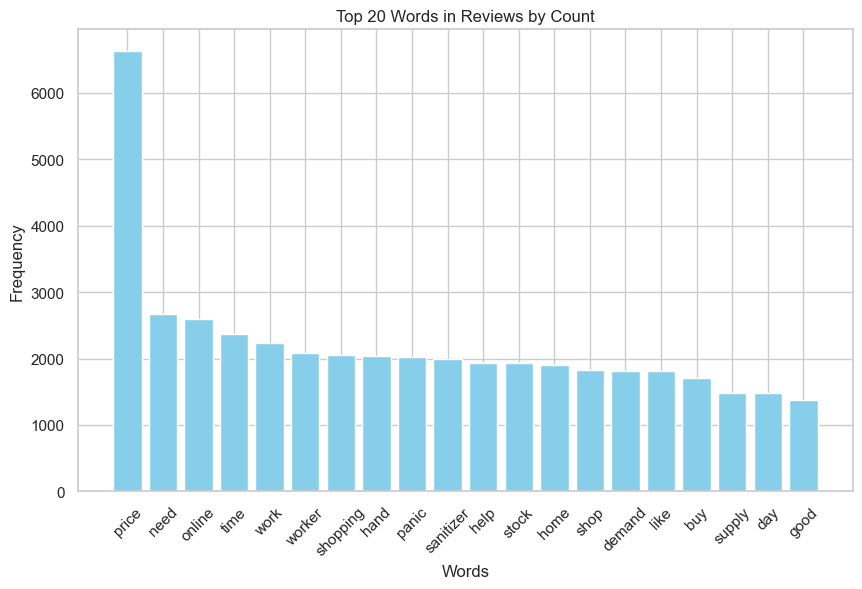

In [45]:
# Let's see the top words
plot_top_n_words(df_train['clean_text'], 20)

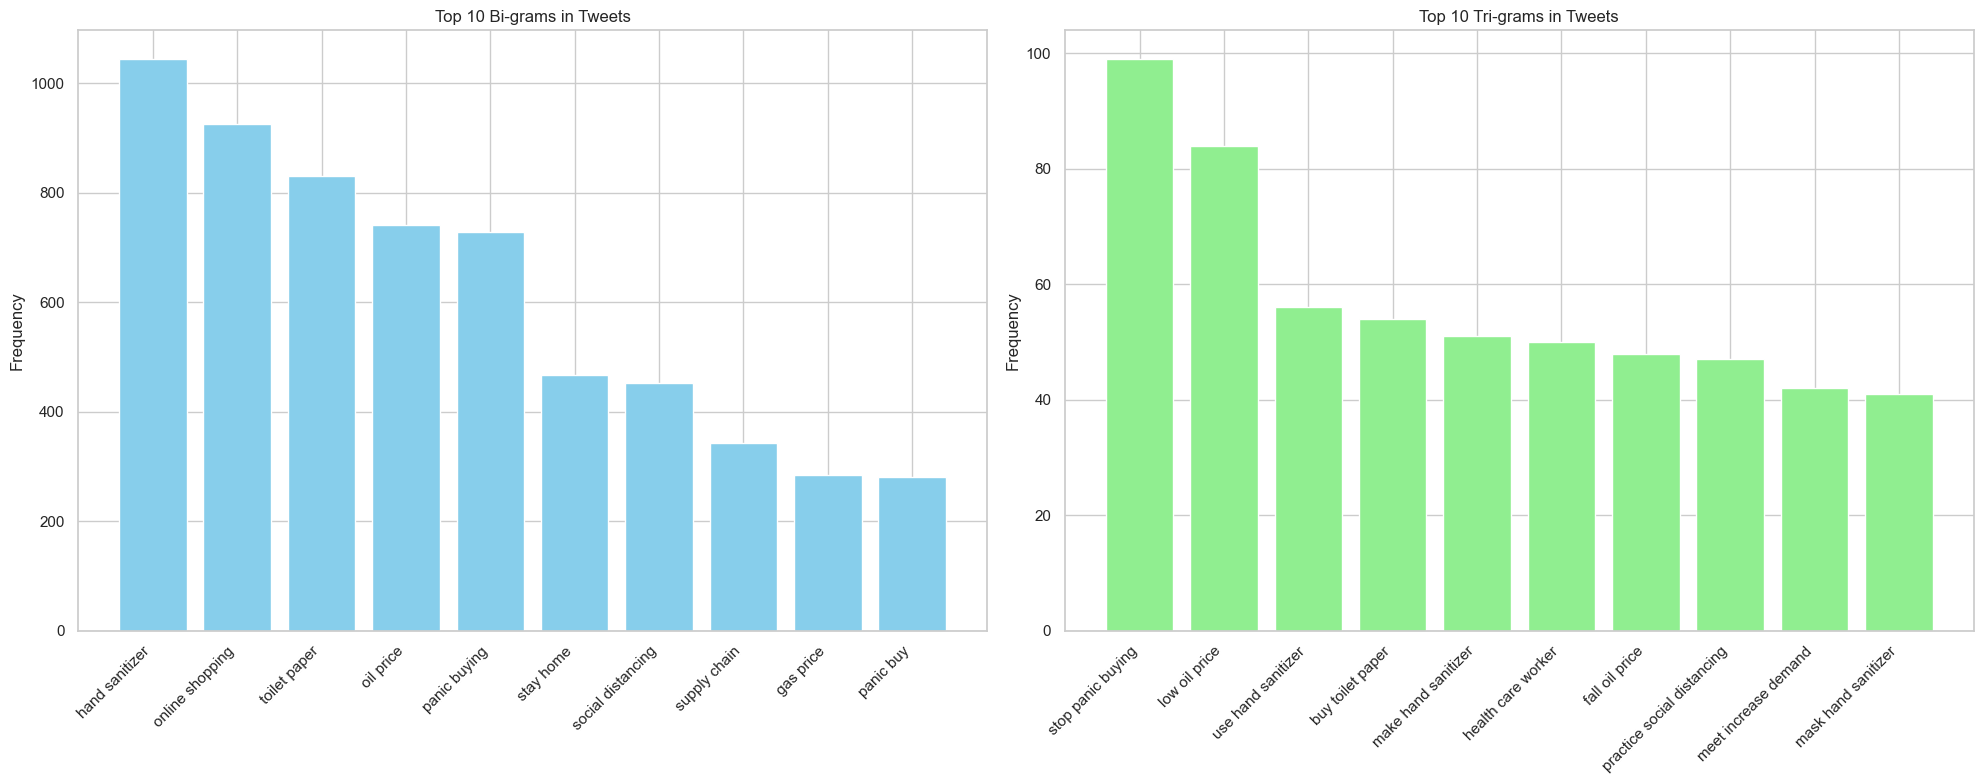

In [50]:
top_bigrams = get_top_n_bigrams(df_train['clean_text'], 10)
top_trigrams = get_top_n_trigrams(df_train['clean_text'], 10)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top Bi-grams
ax1.bar([' '.join(x[0]) for x in top_bigrams], [x[1] for x in top_bigrams], color='skyblue')
ax1.set_title('Top 10 Bi-grams in Tweets')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels([' '.join(x[0]) for x in top_bigrams], rotation=45, ha='right')

# Top Tri-grams
ax2.bar([' '.join(x[0]) for x in top_trigrams], [x[1] for x in top_trigrams], color='lightgreen')
ax2.set_title('Top 10 Tri-grams in Tweets')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels([' '.join(x[0]) for x in top_trigrams], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Not removing price as low/high/fall price may have a different sentiment when coming together in the dataset as can be seen in the n-grams charts. 

In [46]:
# Saving the clean datasets

df_train.to_csv("cl_train.csv")
df_test.to_csv("cl_test.csv")
df_valid.to_csv("cl_valid.csv")

## Treating Imbalance

Trying logistic regression on normal, under-sampled, over-sampled, augmented datasets to see which dataset performs better and then continue with other models.

In [64]:
# Initializing tf-idf vectorizer
tvec = TfidfVectorizer(stop_words= None, max_features=100000, ngram_range=(1, 3))

# Initializing logistic regression instance
lr = LogisticRegression(random_state=7)

### Original imbalanced dataset

In [66]:
%%time
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])
lr_cv(5, df_train['clean_text'], df_train['sentiment'], original_pipeline, 'macro')

              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.63897764 0.64200477 0.48951049 0.64910537 0.48052557]
recall:    [0.48019208 0.54016064 0.51991897 0.56341674 0.60058651]
f1 score:  [0.54832077 0.58669575 0.50425671 0.60323326 0.53388947]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.64308176 0.59930716 0.48970399 0.62235067 0.47644231]
recall:    [0.4909964  0.52056169 0.51418919 0.55737705 0.58123167]
f1 score:  [0.55684139 0.55716586 0.50164799 0.58807465 0.52364597]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.65384615 0.63700234 0.49798928 0.62602366 0.49230029]
recall:    [0.51081731 0.54618474 0.50168805 0.59361519 0.6       ]
f1 score:  [0.57354926 0.58810811 0.49983182 0.60938884 0.5408406 ]
-------------------------------------

In [61]:
%%time
w_lr = LogisticRegression(class_weight='balanced')

weighted_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', w_lr)
])
lr_cv(5, df_train['clean_text'], df_train['sentiment'], weighted_pipeline, 'macro')

              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.5359116  0.54657429 0.50542118 0.58994902 0.52999178]
recall:    [0.69867947 0.71285141 0.40918298 0.69887834 0.37829912]
f1 score:  [0.60656592 0.61873638 0.45223881 0.63981043 0.44147844]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.52925046 0.51900585 0.50474547 0.56559767 0.51989839]
recall:    [0.69507803 0.71213641 0.39527027 0.66954271 0.3601173 ]
f1 score:  [0.60093409 0.60042283 0.44334975 0.61319637 0.42550243]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.5311943  0.53445748 0.50850492 0.57545126 0.55949367]
recall:    [0.71634615 0.73192771 0.38352465 0.68766178 0.3888563 ]
f1 score:  [0.61003071 0.61779661 0.43725943 0.62657233 0.45882353]
-------------------------------------

### Downsampling

In [52]:
RUS_pipeline = make_pipeline(tvec, RandomUnderSampler(random_state=42), lr)

RandomUnderSampler reduces the majority class by randomly removing data from the majority class.

In [53]:
%%time
lr_cv(5, df_train['clean_text'], df_train['sentiment'], RUS_pipeline, 'macro')

              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.51178451 0.52483801 0.46556741 0.54297408 0.49545455]
recall:    [0.72989196 0.73192771 0.32410533 0.68679896 0.31964809]
f1 score:  [0.60168234 0.61132075 0.38216561 0.60647619 0.3885918 ]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.49042465 0.4956229  0.49754661 0.53561453 0.5072324 ]
recall:    [0.70708283 0.73821464 0.34256757 0.66177739 0.3085044 ]
f1 score:  [0.57915438 0.5930701  0.4057623  0.5920494  0.38366156]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.50202758 0.49895761 0.45410628 0.53469388 0.51004016]
recall:    [0.74399038 0.72088353 0.31735314 0.67817084 0.29794721]
f1 score:  [0.59951574 0.58973306 0.3736089  0.59794599 0.37615698]
-------------------------------------

### Oversampling

In [54]:
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=42),lr)
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=42),lr)

#### RandomOverSampler

In [55]:
%%time
lr_cv(5, df_train['clean_text'], df_train['sentiment'], ROS_pipeline, 'macro')

              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.54955839 0.56061839 0.51192369 0.60559006 0.51956522]
recall:    [0.67226891 0.69176707 0.43484132 0.67299396 0.42052786]
f1 score:  [0.60475162 0.61932584 0.47024461 0.63751532 0.46482982]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.53691275 0.53506698 0.49794577 0.57731158 0.50515464]
recall:    [0.67226891 0.68104313 0.40945946 0.64106989 0.40234604]
f1 score:  [0.59701493 0.59929391 0.44938821 0.60752249 0.44792687]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.53651685 0.55852317 0.50126156 0.58295282 0.54778029]
recall:    [0.68870192 0.71385542 0.40243079 0.66091458 0.42697947]
f1 score:  [0.60315789 0.6267078  0.44644195 0.6194905  0.47989453]
-------------------------------------

#### SMOTE

In [56]:
%%time
lr_cv(5, df_train['clean_text'], df_train['sentiment'], SMOTE_pipeline, 'macro')

              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.54929577 0.55929352 0.50588235 0.63746748 0.5003199 ]
recall:    [0.65546218 0.66767068 0.43551654 0.63416739 0.45865103]
f1 score:  [0.59770115 0.60869565 0.46806967 0.63581315 0.47858017]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.54896142 0.52758353 0.51255887 0.6044905  0.50484765]
recall:    [0.66626651 0.68104313 0.44121622 0.60396894 0.42756598]
f1 score:  [0.60195228 0.59457093 0.47421932 0.60422961 0.46300413]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.55257937 0.5495283  0.5        0.62616822 0.53129346]
recall:    [0.66947115 0.70180723 0.43146523 0.63589301 0.44809384]
f1 score:  [0.60543478 0.61640212 0.46321131 0.63099315 0.48615972]
-------------------------------------

- Original imbalanced dataset has average accuracy of 54.53%, precision of 57.29%, recall of 53.96%, and f1 score of 55.21%.
- Weighted logistic regression with imbalanced dataset has lower precision (53.75%) and f1 score (54.65%) than Model 1 but has a higher recall (57.60%).
- Undersampling has lowest performance across all metrics among the five techniques used.
- RandomOversampler has similar performance to original imbalanced dataset, with a slight increase in recall (57.20%) but slightly lower precision (54.15%) and f1 score (55.12%).
- SMOTE shows a balanced performance with an accuracy of 54.54%, the highest precision among all techniques (54.78%), a recall close to the highest at 57.12%, and the highest f1 score (55.58%).

Considering the balance between precision, recall, and f1 score, SMOTE appears to be the most effective, with the highest precision and f1 score, indicating a good balance between the ability to correctly identify sentiments and to do so consistently across different classes. 

Weighted logistic regression with imbalanced dataset is notable for its high recall but at the cost of lower precision and f1 score. High recall indicates the model is good at identifying all relevant instances but may also include more false positives, as indicated by the lower precision.

### Text augmentation

Since oversampling gave the best results, let's try text augmentation using synonyms.

In [115]:
# Assuming df_train is your DataFrame with 'sentiment' and 'tweets' columns
target_size = df_train['sentiment'].value_counts().max()

df_train_new = pd.DataFrame(columns=['clean_text', 'sentiment'])  # Initialize a new DataFrame

for sentiment in df_train['sentiment'].unique():
    sentiment_df = df_train[df_train['sentiment'] == sentiment]

    if len(sentiment_df) < target_size:
        total_augments_needed = target_size - len(sentiment_df)
        print(sentiment, total_augments_needed)
        augment_fn = random.choice([augment_synonym, augment_insertion, augment_shuffle])
        augmented_sentences = augment_sentences(sentiment_df['clean_text'].tolist(), augment_fn, total_augments_needed)
        augmented_df = pd.DataFrame({'clean_text': augmented_sentences, 'sentiment': sentiment})
        df_train_new = pd.concat([df_train_new, augmented_df])

# Add the original data to the new DataFrame
df_train_new = pd.concat([df_train_new, df_train])

# Shuffle the DataFrame
df_train_new = df_train_new.sample(frac=1).reset_index(drop=True)

Neutral 2730
Extremely Negative 4360
Negative 1120
Extremely Positive 3543


In [116]:
df_train_new['sentiment'].value_counts()

sentiment
Positive              8524
Negative              8524
Neutral               8524
Extremely Positive    8524
Extremely Negative    8328
Name: count, dtype: int64

In [117]:
lr_cv(5, df_train_new['clean_text'], df_train_new['sentiment'], original_pipeline, 'macro')

              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.76240049 0.68209256 0.54505076 0.6713323  0.53715968]
recall:    [0.74774775 0.79530792 0.50381232 0.75953079 0.42815249]
f1 score:  [0.75500303 0.73436231 0.52362085 0.71271326 0.47650131]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.76325301 0.69089099 0.56760287 0.66819806 0.52413273]
recall:    [0.7605042  0.81455399 0.50967742 0.76774194 0.40762463]
f1 score:  [0.76187613 0.74764342 0.53708282 0.71451965 0.45859452]
--------------------------------------------------
              Positive, Negative, Neutral, Extremely Positive, Extremely Negative 
precision: [0.76078915 0.69282051 0.5540627  0.65155374 0.51261716]
recall:    [0.74069628 0.79237537 0.50791789 0.75058685 0.4170088 ]
f1 score:  [0.75060827 0.73926129 0.52998776 0.69757295 0.45989651]
-------------------------------------

This dataset has a better performance so we will utilize this to train the model going forward. 

In [118]:
df_train_new.to_csv("aug_train.csv")